In [3]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Code/julia_code/reservoir_learning`


In [4]:
include("Time_series.jl")
using Plots
using LinearAlgebra
using Plots.PlotMeasures
using DelimitedFiles
using DataFrames
using Dates
using CSV
using JLD2
using ShapML
using RDatasets
using MLJ  # Machine learning
using Gadfly  # Plotting
# using LsqFit
using LaTeXStrings

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt /home/ubuntu/.julia/packages/Flux/3711C/ext/FluxCUDAExt/FluxCUDAExt.jl:10


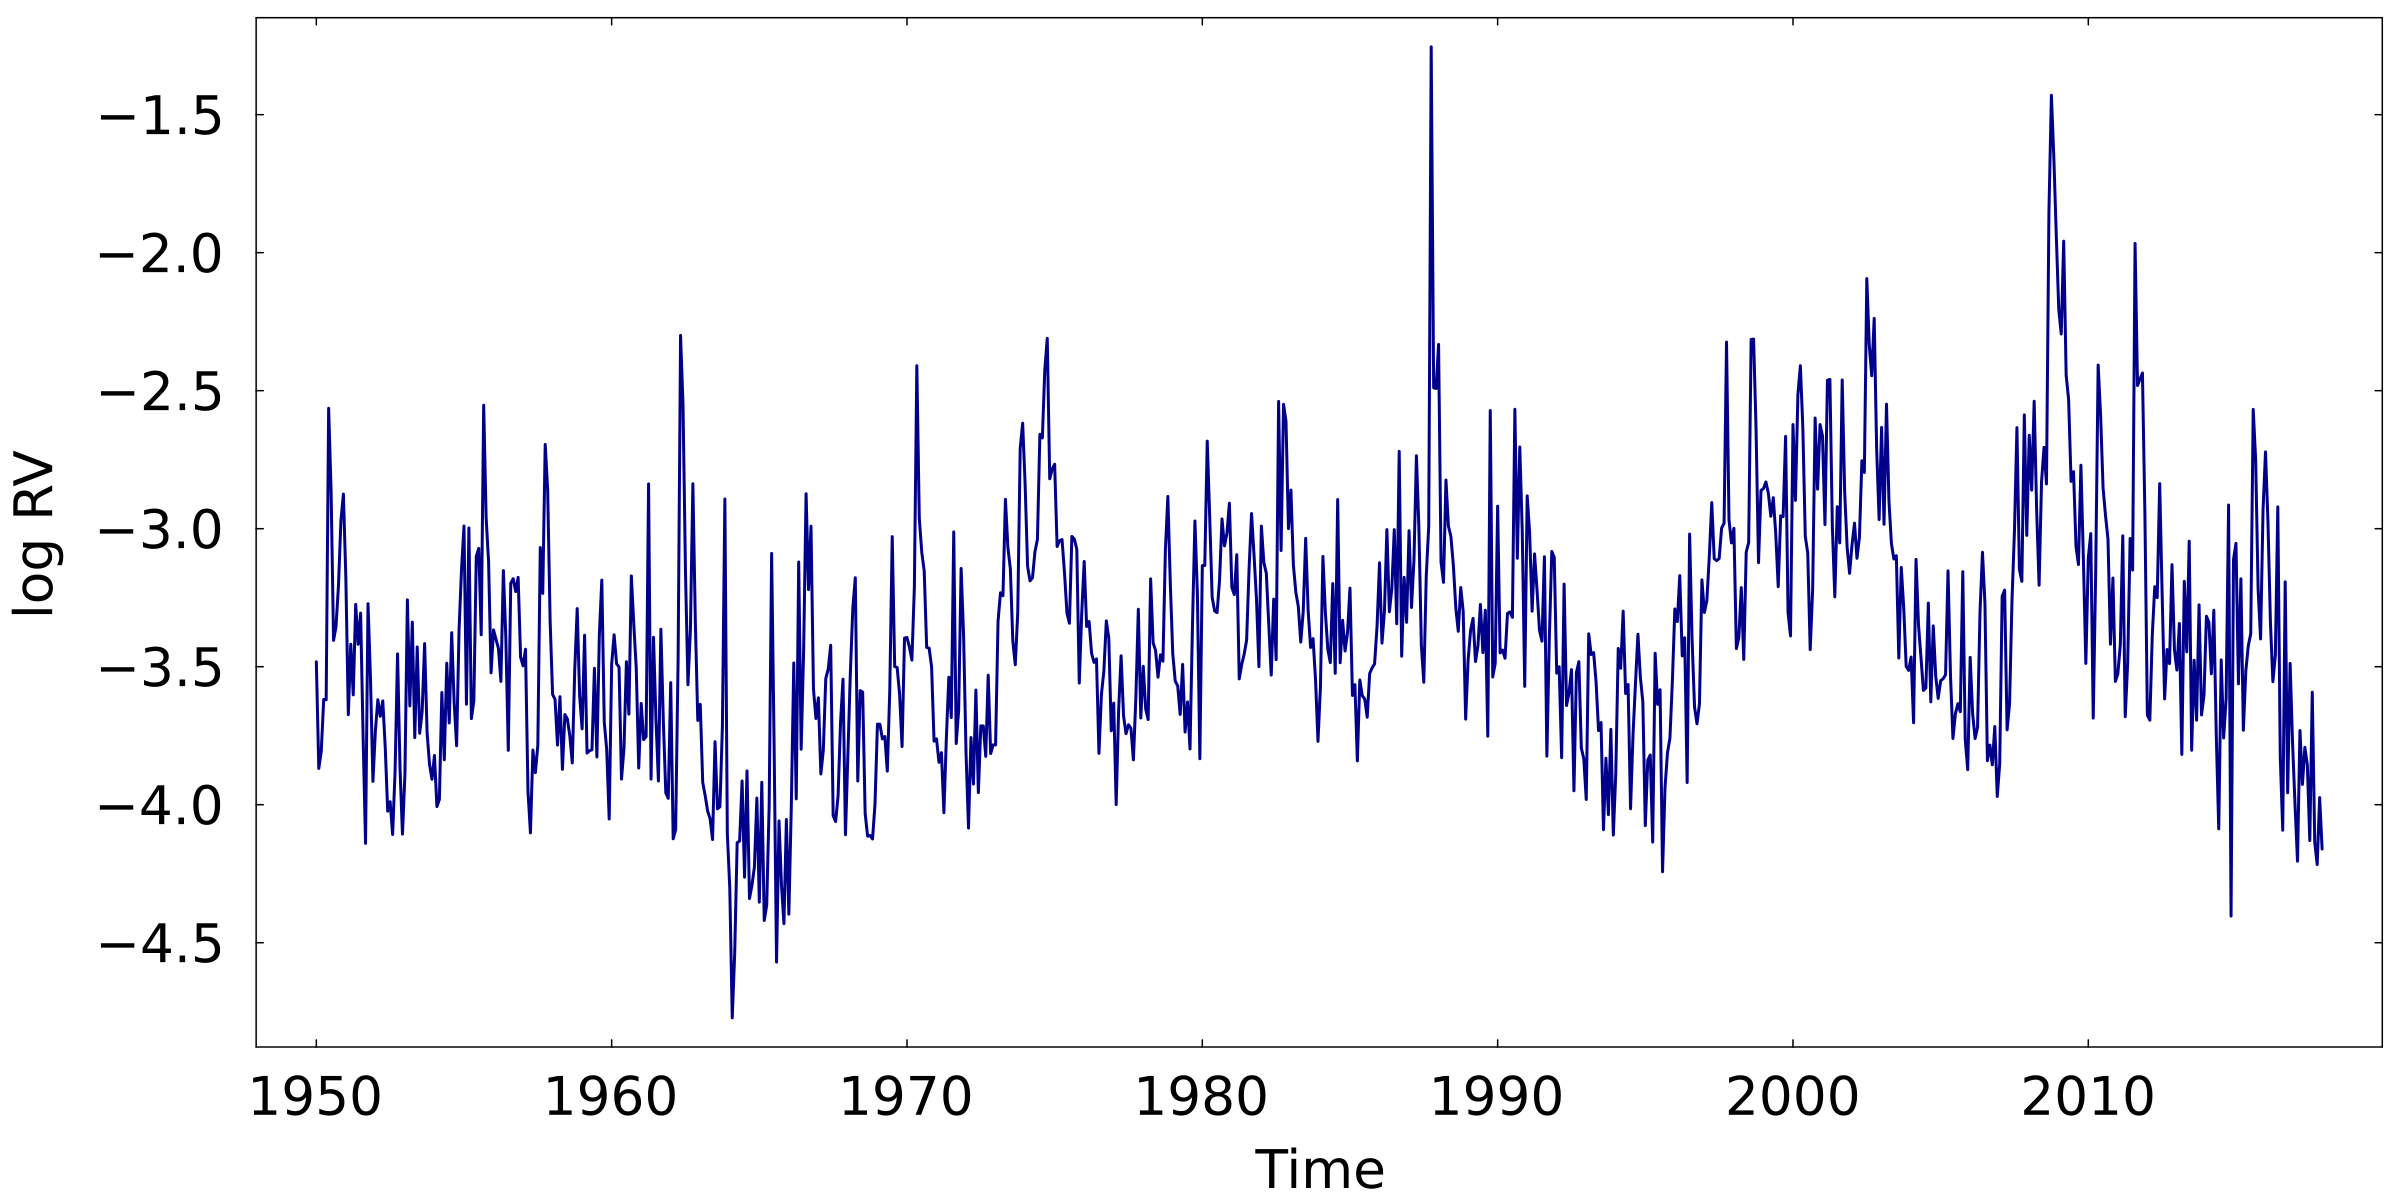

In [5]:
df = CSV.read("output.csv", DataFrame);
Plots.plot(1:816,df.log_return,size=(1600,800),lw=2,
    guidefontsize=24, tickfontsize=24,bottom_margin=10mm, 
    left_margin = 10mm, ylabel="log RV",xlabel="Time",dpi=150,framestyle=:box,grid=false,legend=false,xticks=(1:120:816,["1950", "1960", "1970", "1980", "1990", "2000", "2010"]),color=:darkblue)

In [6]:
savefig("Fig4.png")

"/home/ubuntu/Code/julia_code/reservoir_learning/Fig4.png"

In [7]:
data, header = readdlm("Data.CSV", ',', header=true);
Datas = identity.(DataFrame(data, vec(header)));

In [8]:
nqubit=10
B=[QubitsTerm(i=>Z) for i in 1:nqubit];

In [9]:
# ms=zeros(100,nqubit,nqubit);
# for i in 1:100
#     ms[i,:,:]=coeff_matrix(nqubit,1)
# end
# @save "coeff_8.jld2" ms

# m=readdlm("Coeff.csv")

In [10]:
file = JLD2.load("coeff_10.jld2") 
ms = file["ms"];

In [11]:
Prediction = DataFrame();

In [12]:
τ = 1
LB=length(B)
OutLen = LB
K=3;

In [13]:
#For entire sample forecasting (1997.08-2017.12)
Total = 816# the number of total datasamples =437 for subsample, =816 for entire sample

L=245 # out_of_sample length L=22 for subsample, L=245 for entire sample
wi=Total-L # rolling window length
ws=0# rolling window start index ws=277 for subsample, ws=0 for entire sample

y = Datas."RV"[Total-L+1:Total];

In [14]:
features1 =["RV", "MKT", "DP", "IP", "RV_q", "STR", "DEF"]
Qr1 = Qreservoir(nqubit,ms[1,:,:]);
signal1 = Quantum_Reservoir(Datas, features1, Qr1, B, K, 1, τ, nqubit);
features2 = ["RV", "MKT", "STR","RV_q", "EP", "INF", "DEF"]
Qr2 = Qreservoir(nqubit,ms[2,:,:]);
signal2 = Quantum_Reservoir(Datas, features2, Qr2, B, K, 2, τ, nqubit);

In [15]:
W_paras = zeros(L,OutLen) # the regression parameters of reservoir learning, LB is the number of features.
Pre1 = zeros(L) # the predication realized volatility
# out_of_sample realized volatility
model1 = MyModel(L,OutLen,features1)

for j in 1:L
    #delta = rand()
    y_train = Datas."RV"[ws+j:ws+wi+j-1]#.-delta
    x_train = signal1[:,ws+j:ws+wi+j-1]
    W_paras[j,:]=y_train'*transpose(x_train)*inv(x_train*transpose(x_train)+0.00000001*Matrix(I,OutLen,OutLen))
    Pre1[j]=dot(W_paras[j,:],signal1[:,ws+wi+j])#+delta
    model1.W[j,:] = W_paras[j,:]
end
# QR1=denormalization(Max_RV,Min_RV,Pre1,-1,0)
println("QR1:")
println("Hit rate:$(hitrate(Pre1,y))")
println("MSE: $(MSE(Pre1,y))")
println("RMSE: $(RMSE(Pre1,y))")
println("MAE: $(MAE(Pre1,y))")
println("MAPE: $(MAPE(Pre1,y))")
println("QLike: $(compute_qlike(Pre1,y))")

QR1:
Hit rate:0.44081632653061226
MSE: 0.10508123522429663
RMSE: 0.3241623593576167
MAE: 0.24875430760779038
MAPE: 8.282391106028026
QLike: 1.4427707790572892


In [16]:
model2= MyModel(L,OutLen*2,features2)

W_paras = zeros(L,OutLen*2) # the regression parameters of reservoir learning, LB is the number of features.
Pre2 = zeros(L) # the predication realized volatility
for j in 1:L
    y_train = Datas."RV"[ws+j:ws+wi+j-1]
    x_train = signal2[:,ws+j:ws+wi+j-1]
    W_paras[j,:]=y_train'*transpose(x_train)*inv(x_train*transpose(x_train)+0.00000001*Matrix(I,OutLen*2,OutLen*2))
    Pre2[j]=dot(W_paras[j,:],signal2[:,ws+wi+j])
    model2.W[j,:] = W_paras[j,:]
end
QR2=denormalization(Max_RV,Min_RV,Pre2,-1,0)
println("QR2:")
println("Hit rate:$(hitrate(Pre2,y))")
println("MSE: $(MSE(Pre2,y))")
println("RMSE: $(RMSE(Pre2,y))")
println("MAE: $(MAE(Pre2,y))")
println("MAPE: $(MAPE(Pre2,y))")
println("QLike: $(compute_qlike(Pre2,y))")
# Prediction."QR2"=QR2;

QR2:
Hit rate:0.45714285714285713
MSE: 0.10375599506800008
RMSE: 0.3221117741840557
MAE: 0.24261414851846277
MAPE: 8.173149213585889
QLike: 1.4004040308518164


In [17]:
Years=["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017"];

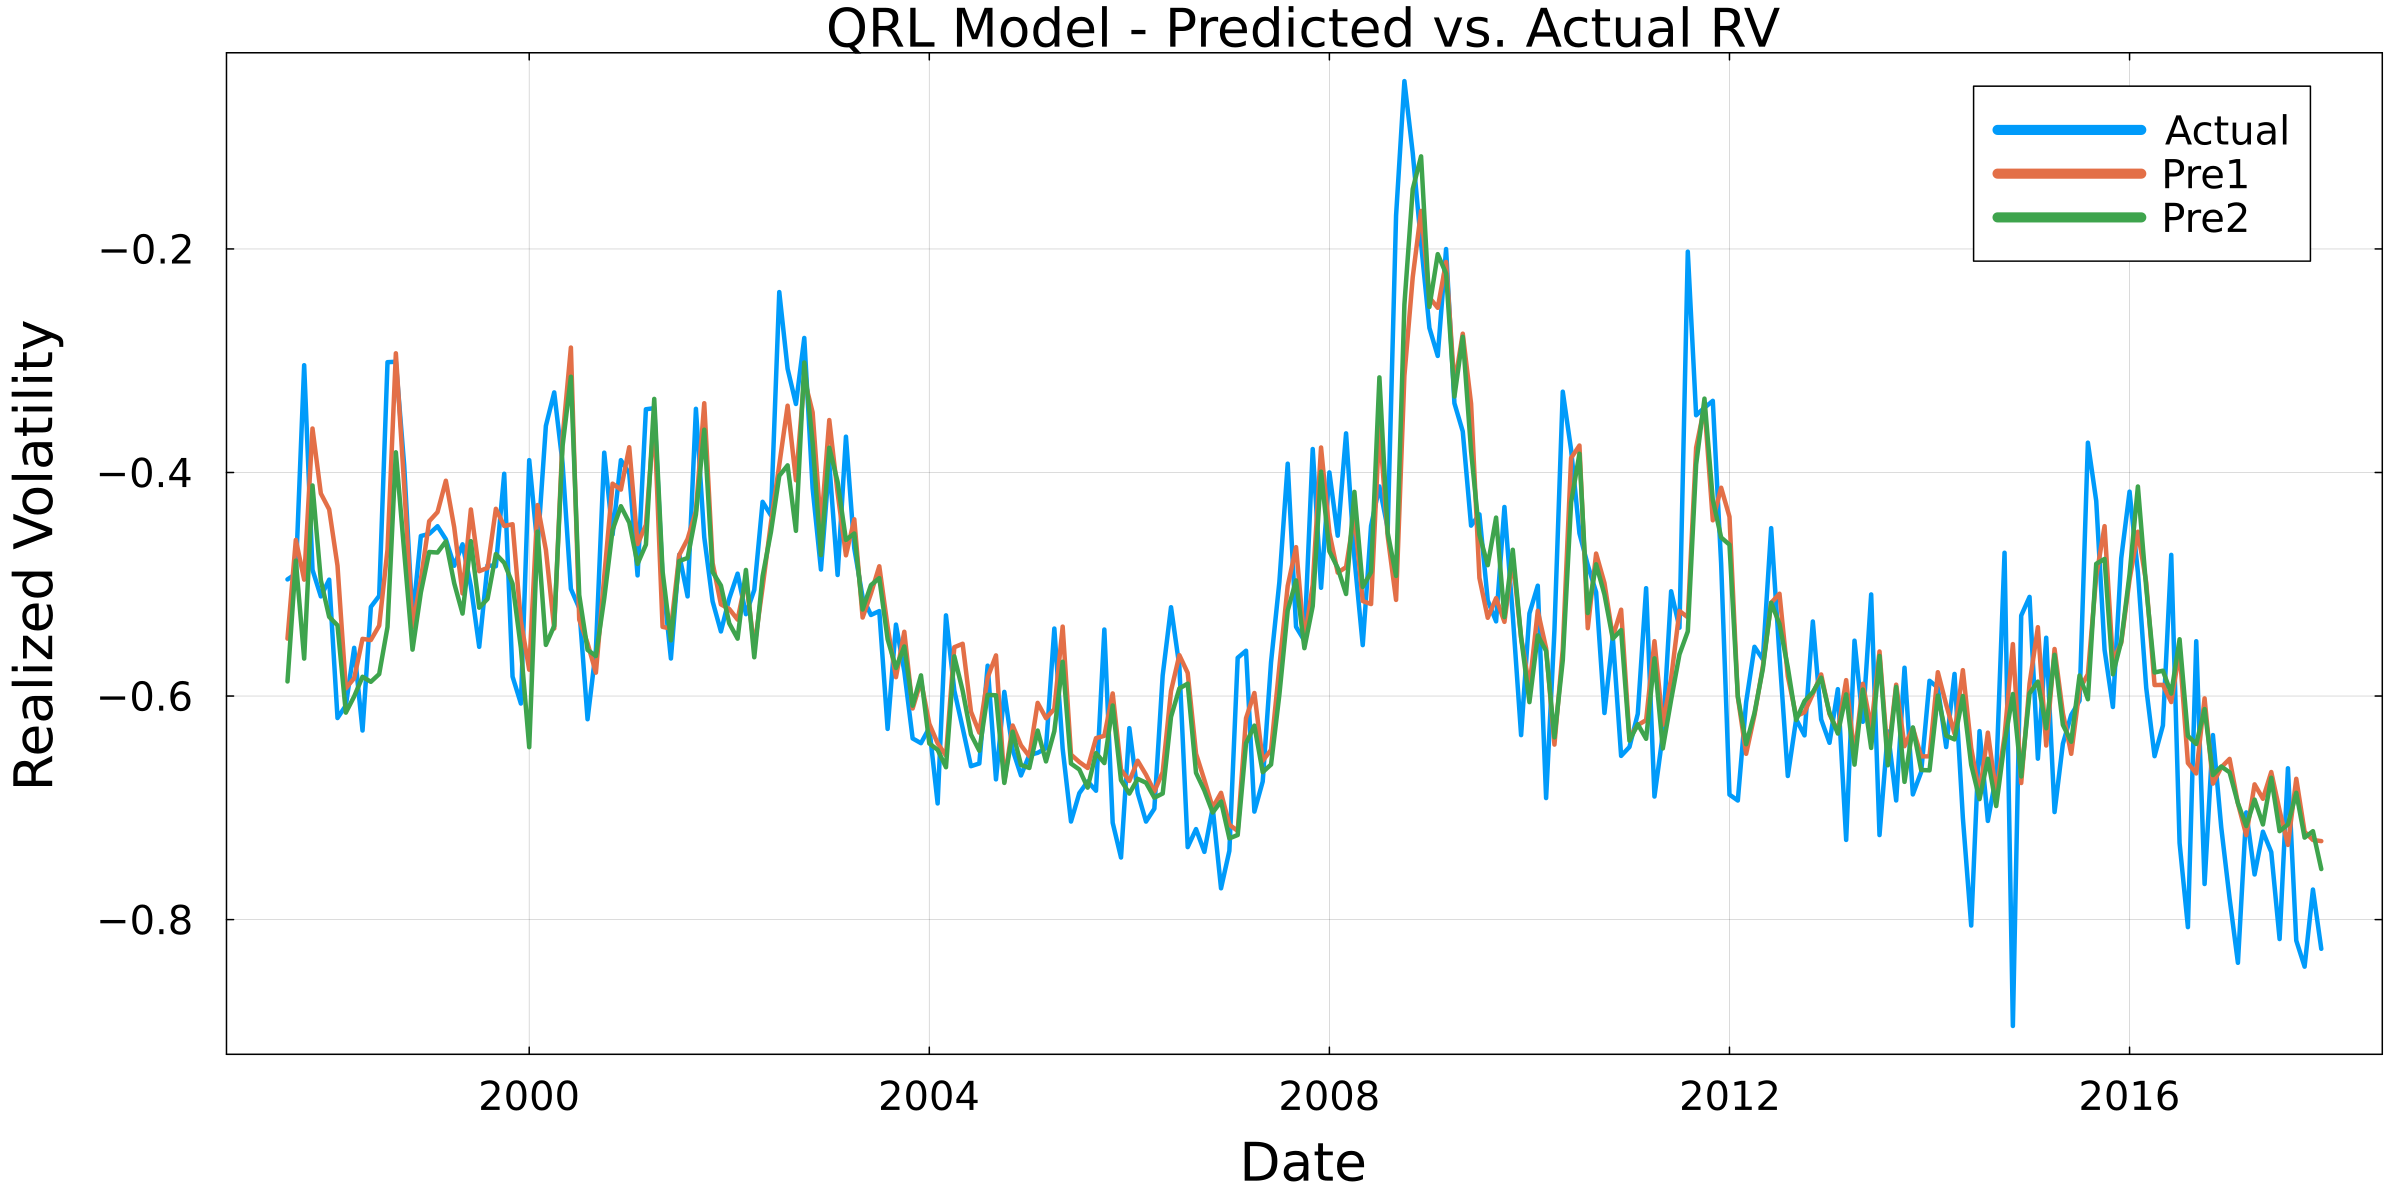

In [18]:
Plots.plot(Vector(Total-L+1:Total),[Datas."RV"[Total-L+1:Total],Pre1, Pre2],
    label=["Actual" "Pre1" "Pre2"],size=(1600,800),lw=3,xticks=(601:48:816,Years[1:4:end]),
    legendfontsize=18, titlefontsize=24, guidefontsize=24, tickfontsize=18,bottom_margin=10mm, 
    left_margin = 10mm, ylabel="Realized Volatility",xlabel="Date",dpi=150,
    title="QRL Model - Predicted vs. Actual RV",framestyle=:box)

In [19]:
color=theme_palette(:auto)

In [ ]:
#best_features=["RV", "MKT", "DP", "IP", "RVq", "STR", "DEF"]# for QR1 ms[1,:,:]
#best_features=["RV", "MKT", "STR","RVq", "EP", "INF", "DEF"];#for QR2 ms[2,:,:]

In [21]:
#CSV.write("predict_result.csv",Prediction)

In [213]:
NewData=DataFrame()
for i in 1:3
    for fea in ["RV", "MKT", "DP", "IP", "RVq", "STR", "DEF"]
        if i == 1
            s=fea*L"_{t-1}"#latexstring(fea,"_{t-$i}")
        elseif i== 2
            s=fea*L"_{t-2}"
        else
            s=fea*L"_{t-3}"
        end
        
        if fea=="RVq"
            NewData[:,"$s"]=shift(Datas[:,"RV_q"],i-1)
        else
            NewData[:,"$s"]=shift(Datas[:,string(fea)],i-1)
        end
    end
end

In [215]:
function predict_function(model::MyModel,Data)
    signal = Quantum_Reservoir_util(Data, model.Features, Qr1, B, K, 1, τ, nqubit);
    Pre = zeros(size(Data,1))
    for l in 1:size(Data,1)
        Pre[l] = dot(model.W[1,:],signal[:,l])
    end
    return DataFrame(y_pred = Pre)
end

predict_function (generic function with 1 method)

In [216]:
reference = copy(NewData[1:Total-L,:])
explain = copy(NewData[Total-L+1:Total-L+20,:]);

sample_size = 20 # Number of Monte Carlo samples.
#------------------------------------------------------------------------------
# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        reference = reference,
                        model = model1,
                        predict_function = predict_function,
                        sample_size = sample_size,
                        seed = 1
                        )

show(data_shap, allcols = true)

420×6 DataFrame
 Row │ index  feature_name  feature_value  shap_effect   shap_effect_sd  intercept 
     │ Int64  String        Float64?       Float64       Float64         Float64   
─────┼─────────────────────────────────────────────────────────────────────────────
   1 │     1  RV$_{t-1}$       -0.495652    0.527893         0.0516096   -0.541877
   2 │     2  RV$_{t-1}$       -0.490684    0.59568          0.096848    -0.541877
   3 │     3  RV$_{t-1}$       -0.304025    0.604662         0.0923116   -0.541877
   4 │     4  RV$_{t-1}$       -0.487062    0.142247         0.065231    -0.541877
   5 │     5  RV$_{t-1}$       -0.510859    0.0625531        0.0641084   -0.541877
   6 │     6  RV$_{t-1}$       -0.495882    0.0518661        0.064541    -0.541877
   7 │     7  RV$_{t-1}$       -0.619658    0.058971         0.0643964   -0.541877
   8 │     8  RV$_{t-1}$       -0.608512   -0.00270334       0.0603902   -0.541877
  ⋮  │   ⋮         ⋮              ⋮             ⋮              ⋮    

In [219]:
#data_plot = DataFrames.by(data_shap, [:feature_name],
#                          mean_effect = [:shap_effect] => x -> mean(abs.(x.shap_effect)))
data_plot = DataFrames.combine(groupby(data_shap,:feature_name), :shap_effect => x -> mean(abs.(x)))

data_plot = sort(data_plot, order(:shap_effect_function, rev = true))
baseline = round(data_shap.intercept[1], digits = 1)

-0.5

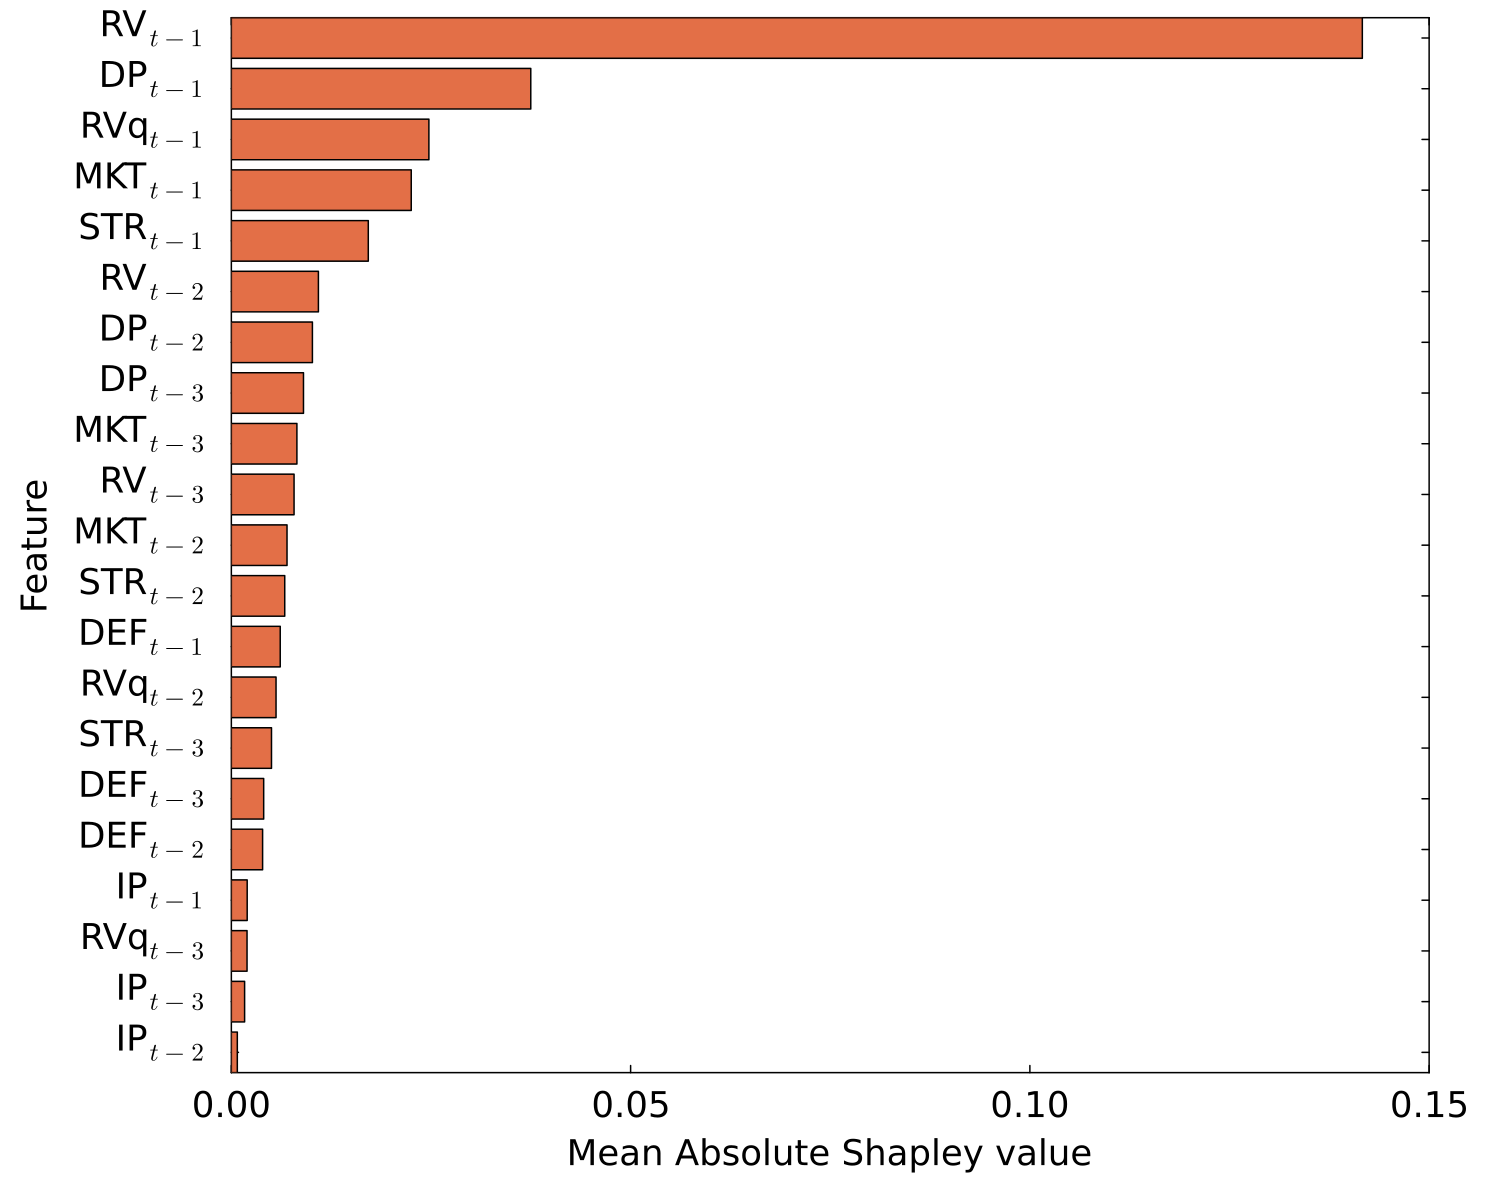

In [220]:
bar(reverse(data_plot.feature_name), reverse(data_plot.shap_effect_function),
    ylabel = "Mean Absolute Shapley value",
    xlabel = "Feature",
    legend = false,
    color = theme_palette(:auto)[2],
    ylims = (0, 0.15),
    titlefontsize=16, guidefontsize=16, tickfontsize=16,
    bottom_margin=5mm, left_margin=5mm,right_margin=10mm,
    dpi=150, permute = (:x, :y),
    size=(1000,800),
    grid = false,frame=:box,xticks=(0.5:1:21,reverse(data_plot.feature_name))
)

In [221]:
savefig("QR1_shap_1.png")

"/home/ubuntu/Code/julia_code/reservoir_learning/QR1_shap_1.png"

In [189]:
NewData_family=DataFrame()
for fea in features1
    if fea == "RVq"
        s = "RV_q"
    else
        s = fea
    end
    d1 = shift(Datas[:,string(s)],0)
    d2 = shift(Datas[:,string(s)],1)
    d3 = shift(Datas[:,string(s)],2)
    dd=Vector()
    for i in 1:length(d1)
        push!(dd,[d1[i],d2[i],d3[i]])
    end
    NewData_family[:,"$s"]=dd
end

In [190]:
function predict_function_family(model::MyModel,Data)
    ddd=zeros(size(Data)[1],size(Data)[2]*3);
    for i in 1:7
        dd= hcat(Data[:,i]...)
        for j in 1:3
            ddd[:,(j-1)*7+i] = dd[j,:]
        end
    end
    signal = Quantum_Reservoir_util(ddd, model.Features, Qr1, B, K, 1, τ, nqubit);
    Pre = zeros(size(Data,1))
    for l in 1:size(Data,1)
        Pre[l] = dot(model.W[1,:],signal[:,l])
    end
    return DataFrame(y_pred = Pre)
end

predict_function_family (generic function with 1 method)

In [191]:
reference = copy(NewData_family[1:Total-L,:])
explain = copy(NewData_family[Total-L+1:Total-L+20,:]);

sample_size = 20 # Number of Monte Carlo samples.
#------------------------------------------------------------------------------
# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        reference = reference,
                        model = model1,
                        predict_function = predict_function_family,
                        sample_size = sample_size,
                        seed = 1)

show(data_shap, allcols = true)

140×6 DataFrame
 Row │ index  feature_name  feature_value                      shap_effect  shap_effect_sd  intercept 
     │ Int64  String        Any                                Float64      Float64         Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1  RV            [-0.495652, -0.527035, -0.529103]   0.491102         0.0348243   -0.55455
   2 │     2  RV            [-0.490684, -0.495652, -0.527035]   0.583197         0.085064    -0.55455
   3 │     3  RV            [-0.304025, -0.490684, -0.495652]   0.605632         0.0774746   -0.55455
   4 │     4  RV            [-0.487062, -0.304025, -0.490684]   0.165213         0.0797015   -0.55455
   5 │     5  RV            [-0.510859, -0.487062, -0.304025]   0.0910926        0.082865    -0.55455
   6 │     6  RV            [-0.495882, -0.510859, -0.487062]   0.0855876        0.0831835   -0.55455
   7 │     7  RV            [-0.619658, -0.495882, -0.510859]  

In [196]:
data_plot = DataFrames.combine(groupby(data_shap,:feature_name), :shap_effect => x -> mean(abs.(x)))

data_plot = sort(data_plot, order(:shap_effect_function, rev = true))
baseline = round(data_shap.intercept[1], digits = 1)

-0.6

In [197]:
name = data_plot.feature_name
index = findfirst(x->x=="RV_q", data_plot.feature_name)
name[index] = "RVq"

"RVq"

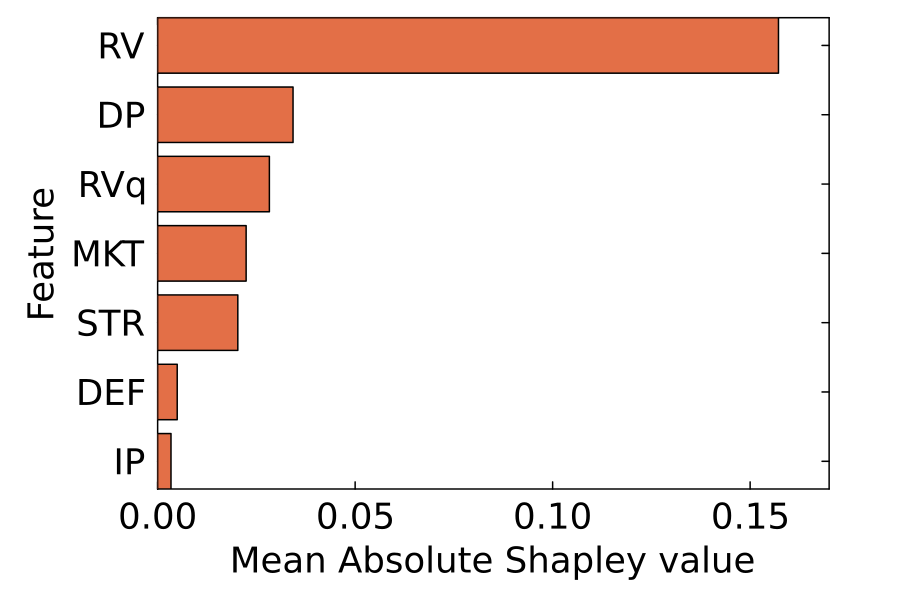

In [198]:
bar(reverse(name), reverse(data_plot.shap_effect_function),
    ylabel = "Mean Absolute Shapley value",
    xlabel = "Feature",
    legend = false,
    color = theme_palette(:auto)[2],
    ylims = (0, 0.17),
    titlefontsize=16, guidefontsize=16, tickfontsize=16,
    bottom_margin=5mm, left_margin=5mm,right_margin=10mm,
    dpi=150, permute = (:x, :y),
    size=(600,400),
    grid = false,frame=:box,xticks=(0.5:1:7,reverse(data_plot.feature_name))
)

In [199]:
savefig("QR1_shap_2.png")

"/home/ubuntu/Code/julia_code/reservoir_learning/QR1_shap_2.png"

In [200]:
NewData_timelag=DataFrame()
for i in 1:3
    d=shift(Matrix(Datas[:,features1]),i-1)
    dd=Vector{Float64}[]
    for j in 1:816
        push!(dd,d[j,:])
    end
    NewData_timelag[:,"F"*"$i"]=dd
end


In [201]:
function predict_function_timelag(model::MyModel,Data)
    ddd=zeros(size(Data)[1],size(NewData_timelag)[2]*7);
    ddd[:,1:7]= hcat(Data[:,1]...)'
    ddd[:,8:14]= hcat(Data[:,2]...)'
    ddd[:,15:21]= hcat(Data[:,3]...)'
    signal = Quantum_Reservoir_util(ddd, model.Features, Qr1, B, K, 1, τ, nqubit);
    Pre = zeros(size(Data,1))
    for l in 1:size(Data,1)
        Pre[l] = dot(model.W[1,:],signal[:,l])
    end
    return DataFrame(y_pred = Pre)
end

predict_function_timelag (generic function with 1 method)

In [202]:
reference = copy(NewData_timelag[1:Total-L,:])
explain = copy(NewData_timelag[Total-L+1:Total-L+20,:]);

sample_size = 20 # Number of Monte Carlo samples.
#------------------------------------------------------------------------------
# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        reference = reference,
                        model = model1,
                        predict_function = predict_function_timelag,
                        sample_size = sample_size,
                        seed = 1
                        )

show(data_shap, allcols = true)

60×6 DataFrame
 Row │ index  feature_name  feature_value                      shap_effect  shap_effect_sd  intercept 
     │ Int64  String        Array…?                            Float64      Float64         Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1  F1            [-0.495652, -0.0294865, 0.085308…   0.475146         0.0287054  -0.547881
   2 │     2  F1            [-0.490684, 0.453482, 0.0837283,…   0.610643         0.0759169  -0.547881
   3 │     3  F1            [-0.304025, -0.0116929, 0.080568…   0.596156         0.0841813  -0.547881
   4 │     4  F1            [-0.487062, 0.332994, 0.0837283,…   0.248079         0.0683717  -0.547881
   5 │     5  F1            [-0.510859, 0.248602, 0.0789889,…   0.137328         0.0777105  -0.547881
   6 │     6  F1            [-0.495882, 0.18912, 0.0789889, …   0.169588         0.074921   -0.547881
   7 │     7  F1            [-0.619658, 0.5394, 0.0647709, 0…   

In [206]:
data_plot = DataFrames.combine(groupby(data_shap,:feature_name), :shap_effect => x -> mean(abs.(x)))
data_plot = sort(data_plot, order(:shap_effect_function, rev = true))
baseline = round(data_shap.intercept[1], digits = 1)

-0.5

In [207]:
data_plot.feature_name

3-element Vector{String}:
 "F1"
 "F2"
 "F3"

In [208]:
name = ["F"*L"_{t-1}", "F"*L"_{t-2}", "F"*L"_{t-3}"]

3-element Vector{String}:
 "F\$_{t-1}\$"
 "F\$_{t-2}\$"
 "F\$_{t-3}\$"

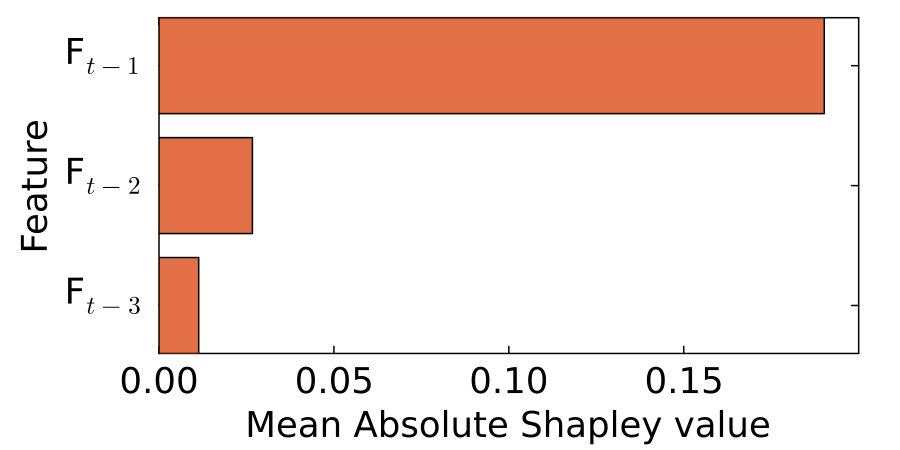

In [210]:
bar(reverse(name), reverse(data_plot.shap_effect_function),
    ylabel = "Mean Absolute Shapley value",
    xlabel = "Feature",
    legend = false,
    color = theme_palette(:auto)[2],
    ylims = (0, 0.2),
    titlefontsize=16, guidefontsize=16, tickfontsize=16,
    bottom_margin=5mm, left_margin=5mm,right_margin=5mm,
    dpi=150, permute = (:x, :y),
    size=(600,300),
    grid = false,frame=:box,xticks=(0.5:1:3,reverse(name))
)

In [211]:
savefig("QR1_shap_3.png")

"/home/ubuntu/Code/julia_code/reservoir_learning/QR1_shap_3.png"